In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

In [2]:
df_trees_raw = pd.read_csv("../../data/raw/raw_trainset.csv")
df = df_trees_raw.copy()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(by=["id", "time"]).reset_index(drop=True)#.sample(frac=0.6)
df["month"] = df["time"].dt.month

In [3]:
df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,b8,b8a,b11,b12,species,month
0,2017-03-13,1,0,72,147,204,145,400,1193,1435,1593,1642,672,347,Norway_spruce_mixed,3
1,2017-03-27,1,0,86,137,222,154,389,1247,1561,1557,1747,743,388,Norway_spruce_mixed,3
2,2017-04-09,1,0,99,160,248,169,395,1209,1454,1530,1786,674,327,Norway_spruce_mixed,4
3,2017-04-22,1,0,112,146,247,152,391,1354,1628,1672,1878,673,305,Norway_spruce_mixed,4
4,2017-04-29,1,0,119,171,264,186,419,1353,1731,1806,1938,743,325,Norway_spruce_mixed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074349,2022-09-05,28212,0,248,318,450,338,619,1664,2012,2271,2322,912,444,Scots_pine,9
4074350,2022-09-24,28212,0,267,202,334,229,513,1666,2136,2247,2206,774,327,Scots_pine,9
4074351,2022-10-03,28212,0,276,184,311,205,504,1580,1910,1992,2078,699,312,Scots_pine,10
4074352,2022-10-27,28212,0,300,353,560,362,732,1944,2254,2530,2515,832,393,Scots_pine,10


Training: 100%|█████████████████████████████████████████████████| 144/144 [1:38:39<00:00, 41.11s/it]


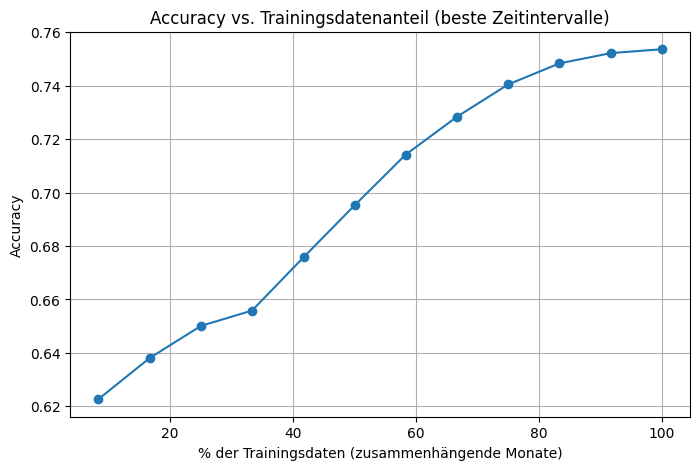

Ergebnisse:
8.3% Daten → Accuracy = 0.623 → Monate: [9]
16.7% Daten → Accuracy = 0.638 → Monate: [9, 10]
25.0% Daten → Accuracy = 0.650 → Monate: [9, 10, 11]
33.3% Daten → Accuracy = 0.656 → Monate: [2, 3, 4, 5]
41.7% Daten → Accuracy = 0.676 → Monate: [3, 4, 5, 6, 7]
50.0% Daten → Accuracy = 0.695 → Monate: [9, 10, 11, 12, 1, 2]
58.3% Daten → Accuracy = 0.714 → Monate: [11, 12, 1, 2, 3, 4, 5]
66.7% Daten → Accuracy = 0.728 → Monate: [10, 11, 12, 1, 2, 3, 4, 5]
75.0% Daten → Accuracy = 0.740 → Monate: [9, 10, 11, 12, 1, 2, 3, 4, 5]
83.3% Daten → Accuracy = 0.748 → Monate: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
91.7% Daten → Accuracy = 0.752 → Monate: [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
100.0% Daten → Accuracy = 0.754 → Monate: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [5]:
# ----------------------------
# 2️⃣ Hilfsfunktionen
# ----------------------------
def train_and_score(train_df, test_df):
    X_train = train_df.drop(columns=["species", "time", "month", "id"])
    y_train = train_df["species"]
    X_test = test_df.drop(columns=["species", "time", "month", "id"])
    y_test = test_df["species"]

    model = RandomForestClassifier(n_estimators=15, n_jobs=8, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

def get_interval_months(start, length):
    """Ermöglicht Wrap-Around: z. B. [11,12,1]"""
    return [(start + i - 1) % 12 + 1 for i in range(length)]

# ----------------------------
# 3️⃣ Globale Test-IDs vorbereiten (GEÄNDERT)
# ----------------------------
# Daten pro Monat vorbereiten (bleibt gleich)
months = [df[df["month"] == m] for m in range(1, 13)]

# NEU: Wählen Sie eine feste Stichprobe von IDs aus den gesamten Daten zum Testen
all_unique_ids = df["id"].unique()
# Mischen Sie die IDs, um eine zufällige Stichprobe zu erhalten
rng = np.random.default_rng(42)
rng.shuffle(all_unique_ids) 

# Definiere die Anzahl oder den Prozentsatz der IDs für den globalen Test-Datensatz
test_ratio = 0.2
num_test = max(1, int(test_ratio * len(all_unique_ids))) 

# Die globalen Test-IDs
# Die globale Test-ID-Liste enthält IDs aus dem gesamten Datensatz 'df'
global_test_ids = all_unique_ids[:num_test] 

# NEU: Erstellen des globalen Test-Datensatzes einmalig
# test_df enthält nun nur Daten, deren 'id' in den global_test_ids enthalten ist,
# aus dem GESAMTEN Datensatz 'df' (unabhängig vom aktuellen Intervall)
global_test_df = df[df["id"].isin(global_test_ids)].copy() 
# Entfernen Sie die 'global_test_ids' aus dem Trainingspool, um Leckagen zu verhindern
df_train_pool = df[~df["id"].isin(global_test_ids)].copy()

# ----------------------------
# 4️⃣ Alle Intervalllängen testen (GEÄNDERT)
# ----------------------------
results = {}
intervals = {}
total_steps = 12 * 12 

with tqdm(total=total_steps, desc="Training", ncols=100) as pbar:
    for length in range(1, 13): # 1 bis 12 Monate
        best_acc = -1
        best_months = None
        
        for start in range(1, 13): # Startmonat 1–12
            months_in_interval = get_interval_months(start, length)
            
            # Hole Daten für diesen Intervall NUR aus dem Trainingspool
            # Das ist die Änderung: Wir trainieren nur auf den Daten, 
            # die NICHT in 'global_test_ids' enthalten sind
            months_to_train_on = [m for m in months_in_interval]
            
            # Filtern des Trainingspools (df_train_pool) nach den Monats-IDs
            train_df = df_train_pool[df_train_pool["month"].isin(months_to_train_on)]
            
            # Der Test-Datensatz bleibt global und fixiert
            test_df = global_test_df
            
            # Sicherstellen, dass train_df nicht leer ist, um Fehler zu vermeiden
            if train_df.empty:
                acc = 0.0 # Kann passieren, wenn das Intervall keine Daten enthält
            else:
                acc = train_and_score(train_df, test_df)

            if acc > best_acc:
                best_acc = acc
                best_months = months_in_interval
            
            pbar.update(1)

        percent = length / 12 * 100
        results[round(percent, 1)] = best_acc
        intervals[round(percent, 1)] = best_months

# ----------------------------
# 5️⃣ Plot erstellen
# ----------------------------
x, y = zip(*sorted(results.items()))
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o')
plt.xlabel('% der Trainingsdaten (zusammenhängende Monate)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Trainingsdatenanteil (beste Zeitintervalle)')
plt.grid(True)
plt.show()

# ----------------------------
# 6️⃣ Ergebnisse anzeigen
# ----------------------------
print("Ergebnisse:")
for p, acc in results.items():
    mons = intervals[p]
    print(f"{p}% Daten → Accuracy = {acc:.3f} → Monate: {mons}")
